In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
df = pd.read_csv("emotion_sentimen_dataset.csv")
df.head()


,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [3]:
def clean_text(text):
    text = nt.remove_emojis(text)
    text = nt.remove_urls(text)
    text = nt.remove_puncts(text)
    text = nt.remove_numbers(text)
    text = text.lower().strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)
df.head()


,Unnamed: 0,text,Emotion,clean_text
0,0,i seriously hate one subject to death but now ...,hate,i seriously hate one subject to death but now ...
1,1,im so full of life i feel appalled,neutral,im so full of life i feel appalled
2,2,i sit here to write i start to dig out my feel...,neutral,i sit here to write i start to dig out my feel...
3,3,ive been really angry with r and i feel like a...,anger,ive been really angry with r and i feel like a...
4,4,i feel suspicious if there is no one outside l...,neutral,i feel suspicious if there is no one outside l...


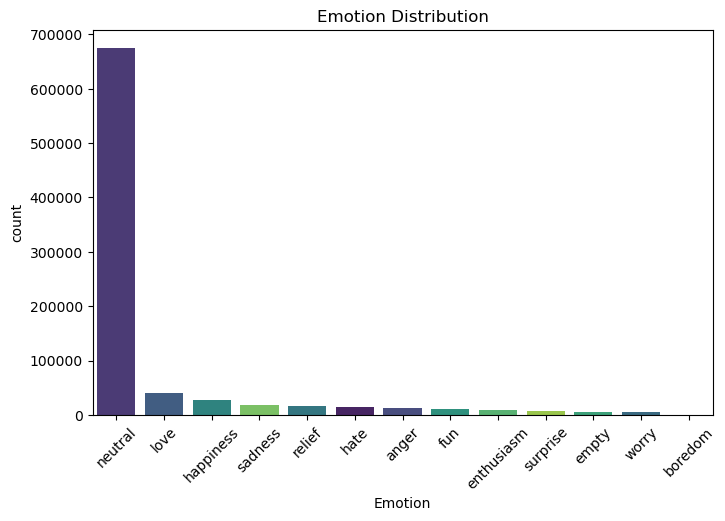

In [45]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Emotion", hue="Emotion", order=df["Emotion"].value_counts().index, palette="viridis", legend=False)
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()


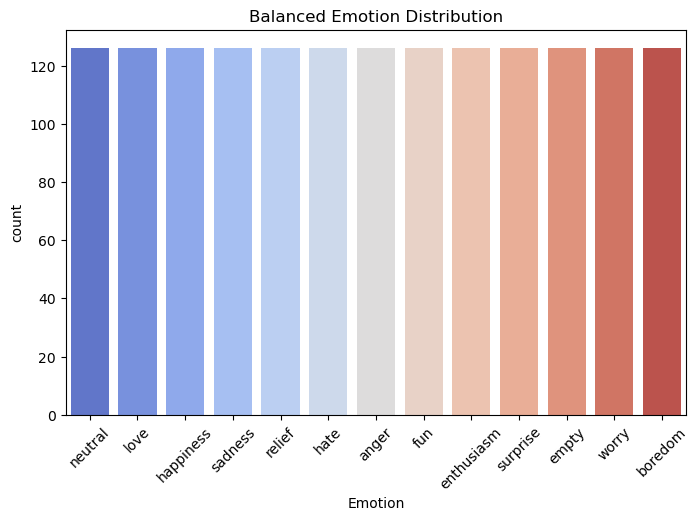

In [46]:
top_emotions = df["Emotion"].value_counts().index  
min_count = df["Emotion"].value_counts().min()
df_balanced = pd.concat([df[df["Emotion"] == emo].sample(min_count, random_state=42) for emo in top_emotions])

plt.figure(figsize=(8, 5))
sns.countplot(data=df_balanced, x="Emotion", hue="Emotion", order=top_emotions, palette="coolwarm", legend=False)
plt.title("Balanced Emotion Distribution")
plt.xticks(rotation=45)
plt.show()


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["clean_text"], df_balanced["Emotion"], test_size=0.2, stratify=df_balanced["Emotion"], random_state=42
)


In [48]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2), stop_words='english', sublinear_tf=True, smooth_idf=True)  
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [49]:
model = RandomForestClassifier(n_estimators=120, max_depth=20, min_samples_split=3, min_samples_leaf=2, random_state=42, n_jobs=-1, class_weight="balanced")  
model.fit(X_train_vec, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=120, n_jobs=-1, random_state=42)

In [50]:
# model = RandomForestClassifier(n_estimators=80, max_depth=15, min_samples_split=3, random_state=42)
# model.fit(X_train_vec, y_train)


In [51]:
y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8445121951219512

Classification Report:
               precision    recall  f1-score   support

       anger       0.84      0.84      0.84        25
     boredom       1.00      1.00      1.00        25
       empty       0.60      0.48      0.53        25
  enthusiasm       1.00      0.96      0.98        26
         fun       0.83      0.80      0.82        25
   happiness       0.86      0.96      0.91        25
        hate       0.84      0.81      0.82        26
        love       0.89      0.96      0.92        25
     neutral       0.44      0.72      0.55        25
      relief       1.00      0.88      0.94        25
     sadness       0.96      0.88      0.92        26
    surprise       1.00      0.84      0.91        25
       worry       1.00      0.84      0.91        25

    accuracy                           0.84       328
   macro avg       0.87      0.84      0.85       328
weighted avg       0.87      0.84      0.85       328



In [52]:
joblib.dump(model, "emotion_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [53]:
def predict_emotion(user_input):
    model = joblib.load("emotion_classifier.pkl")
    vectorizer = joblib.load("tfidf_vectorizer.pkl")
    user_input_clean = clean_text(user_input)
    user_vec = vectorizer.transform([user_input_clean])
    return model.predict(user_vec)[0]

while True:
    user_input = input("Enter a sentence (or '1' to stop): ").strip()
    if user_input.lower() == "1":
        break
    print(f"Predicted Emotion: {predict_emotion(user_input)}\n")


Enter a sentence (or '1' to stop):  i am happy today


Predicted Emotion: happiness



Enter a sentence (or '1' to stop):  i am feeling sad today


Predicted Emotion: sadness



Enter a sentence (or '1' to stop):  i am going to market 


Predicted Emotion: neutral



Enter a sentence (or '1' to stop):  1
